# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [2]:
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score






/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [3]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [4]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [4]:
X_train_norm = X_train.astype("float32") / 255.0
X_test_norm = X_test.astype("float32") / 255.0
# One-hot encode for NN
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Flatten images for Random Forest & MLP
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Scale features for Random Forest & MLP (optional but helps MLP)
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

In [14]:
X_train_flat.shape

(50000, 3072)

In [6]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Smaller subset for speed
X_train_rf = X_train_flat
y_train_rf = y_train.ravel()
X_val_rf = X_test_flat
y_val_rf = y_test.ravel()

# Grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None]
}

rf = RandomForestClassifier(n_jobs=-1)

grid = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=2)
grid.fit(X_train_rf, y_train_rf)

print("Best parameters:", grid.best_params_)
print("Best validation accuracy:", grid.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ......................max_depth=10, n_estimators=50; total time=   9.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=  11.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=  10.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=  14.8s
[CV] END ......................max_depth=20, n_estimators=50; total time=  10.0s
[CV] END ......................max_depth=20, n_estimators=50; total time=   9.4s
[CV] END ......................max_depth=20, n_estimators=50; total time=   9.5s
[CV] END .....................max_depth=20, n_estimators=100; total time=  18.3s
[CV] END .....................max_depth=20, n_estimators=100; total time=  22.4s
[CV] END .....................max_depth=20, n_est

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
X_train_rf = X_train_flat
y_train_rf = y_train.ravel()
X_val_rf = X_test_flat
y_val_rf = y_test.ravel()
# --- Define parameter grid ---
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 10],
}

# Initialize the base model
gbm = GradientBoostingClassifier(random_state=42)

# Define cross-validation strategy
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Perform GridSearchCV with the first param_grid
grid_search_1 = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=param_grid,
    n_iter=5,          
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search_1.fit(X_train_rf[:2000], y_train_rf[:2000])

# --- Results ---
print("Best Parameters:", grid_search_1.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_1.best_score_)    

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=10.8min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=10.8min
[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=10.8min
[CV] END .learning_rate=0.001, max_depth=10, n_estimators=50; total time=22.2min
[CV] END .learning_rate=0.001, max_depth=10, n_estimators=50; total time=22.2min
[CV] END .learning_rate=0.001, max_depth=10, n_estimators=50; total time=23.7min
[CV] END learning_rate=0.001, max_depth=10, n_estimators=100; total time=46.8min
[CV] END learning_rate=0.001, max_depth=10, n_estimators=100; total time=46.9min
[CV] END learning_rate=0.001, max_depth=10, n_estimators=100; total time=47.2min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=46.8min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=47.4min
[CV] END ..learning_rate=0.1, max_depth=10, n_est

In [7]:
grid_search_1.best_score_

np.float64(0.3370011690851271)

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold

# --- Prepare data subset for faster training ---
X_train_ab = X_train_flat[:5000]
y_train_ab = y_train[:5000].ravel()
X_test_ab = X_test_flat[:2000]
y_test_ab = y_test[:2000].ravel()

# --- Define base learner ---
base_tree = DecisionTreeClassifier(max_depth=3)

# --- Initialize AdaBoost ---
ada = AdaBoostClassifier(estimator=base_tree, random_state=42)

# --- Define parameter distributions ---
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

# --- Cross-validation strategy ---
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# --- Randomized search for speed ---
search = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_distributions,
    n_iter=5,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

search.fit(X_train_ab, y_train_ab)

print("Best Params:", search.best_params_)
print("Best CV Accuracy:", search.best_score_)

# --- Evaluate on test set ---
y_pred_ada = search.best_estimator_.predict(X_test_ab)
print("Test Accuracy:", accuracy_score(y_test_ab, y_pred_ada))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarn

[CV] END .................learning_rate=0.5, n_estimators=50; total time= 1.5min
[CV] END .................learning_rate=0.5, n_estimators=50; total time= 1.5min


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END .................learning_rate=0.5, n_estimators=50; total time= 1.6min
[CV] END ................learning_rate=0.5, n_estimators=100; total time= 3.1min
[CV] END ................learning_rate=0.5, n_estimators=100; total time= 3.1min


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=0.5, n_estimators=200; total time= 6.1min


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END .................learning_rate=1.0, n_estimators=50; total time= 1.5min


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END ................learning_rate=1.0, n_estimators=200; total time= 6.2min
[CV] END ................learning_rate=1.0, n_estimators=200; total time= 6.2min
[CV] END ................learning_rate=0.5, n_estimators=200; total time= 6.2min
[CV] END ................learning_rate=1.0, n_estimators=200; total time= 6.2min
[CV] END ................learning_rate=0.5, n_estimators=200; total time= 6.0min
[CV] END .................learning_rate=1.0, n_estimators=50; total time= 1.3min
[CV] END .................learning_rate=1.0, n_estimators=50; total time= 1.3min
[CV] END ................learning_rate=0.5, n_estimators=100; total time= 2.9min


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Params: {'n_estimators': 50, 'learning_rate': 0.5}
Best CV Accuracy: 0.2867995428525339
Test Accuracy: 0.3295


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

def build_mlp(hidden_units=[512, 256], dropout=0.5, lr=0.001):
    model = Sequential()
    model.add(Flatten(input_shape=(32,32,3)))
    for units in hidden_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Try different configurations
configs = [
    {'hidden_units':[256,128], 'dropout':0.3},
    {'hidden_units':[512,256], 'dropout':0.5},
]

for cfg in configs:
    print(f"Testing config: {cfg}")
    mlp = build_mlp(hidden_units=cfg['hidden_units'], dropout=cfg['dropout'])
    mlp.fit(X_train_norm, y_train_cat,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=1)
    val_loss, val_acc = mlp.evaluate(X_test_norm, y_test_cat)
    print("Test Accuracy:", val_acc)

Testing config: {'hidden_units': [256, 128], 'dropout': 0.3}


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1879 - loss: 2.2108 - val_accuracy: 0.3081 - val_loss: 1.9269
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2731 - loss: 1.9560 - val_accuracy: 0.3429 - val_loss: 1.8631
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2989 - loss: 1.9143 - val_accuracy: 0.3283 - val_loss: 1.8549
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3024 - loss: 1.8953 - val_accuracy: 0.3563 - val_loss: 1.7874
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3187 - loss: 1.8535 - val_accuracy: 0.3685 - val_loss: 1.7770
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3191 - loss: 1.8469 - val_accuracy: 0.3480 - val_loss: 1.7975
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3241 - loss: 1.8393 - val_accuracy: 0.3589 - val_loss: 1.7863
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3289 - loss: 1.8315 - val_accuracy: 0.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn(num_filters=[32,64], dense_units=128, dropout=0.5):
    model = Sequential()
    model.add(Conv2D(num_filters[0], (3,3), activation='relu', input_shape=(32,32,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(num_filters[1], (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Configurations to try
cnn_configs = [
    {'num_filters':[32,64], 'dense_units':128, 'dropout':0.5},
    {'num_filters':[64,128], 'dense_units':256, 'dropout':0.3},
]

for cfg in cnn_configs:
    print(f"Testing config: {cfg}")
    cnn = build_cnn(**cfg)
    cnn.fit(X_train_norm, y_train_cat,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=1)
    val_loss, val_acc = cnn.evaluate(X_test_norm, y_test_cat)
    print("Test Accuracy:", val_acc) 

Testing config: {'num_filters': [32, 64], 'dense_units': 128, 'dropout': 0.5}
Epoch 1/10


/Users/stephensusanto/Desktop/Intro to Programming/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2616 - loss: 1.9870 - val_accuracy: 0.4640 - val_loss: 1.5091
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4404 - loss: 1.5420 - val_accuracy: 0.5258 - val_loss: 1.3540
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4900 - loss: 1.4223 - val_accuracy: 0.5656 - val_loss: 1.2435
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5244 - loss: 1.3270 - val_accuracy: 0.5917 - val_loss: 1.1726
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5561 - loss: 1.2443 - val_accuracy: 0.5778 - val_loss: 1.1808
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5781 - loss: 1.1838 - val_accuracy: 0.6147 - val_loss: 1.1087
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5945 - loss: 1.1416 - val_accuracy: 0.6242 - val_loss: 1.0594
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6052 - loss: 1.1083 - val_accuracy: 0.646

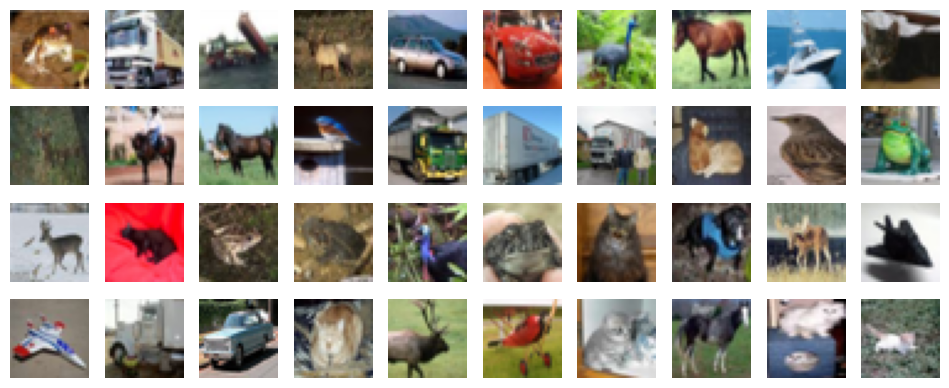

In [23]:
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of MNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

plot_examples(X_train)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network